In [1]:
import torch
import sys, os
module_rootdir = '../../..'
dataset_rootdir = '../../../..'
label_rootdir = module_rootdir
sys.path.append(module_rootdir)
import config_dataset
from modules.dataset_utils.bdd_dataset_utils import constants
from modules.proposal.constants import _IGNORED_CLASS_DEFAULT_ID_
from modules.dataset_utils.bdd_dataset_and_dataloader import BerkeleyDeepDriveDataset, extract_valid_bbox
from modules.proposal.box_association import fcos_match_locations_to_gt_main
from modules.proposal.box_functions import gen_grid_coord
from modules.plot.viz_annotation import vizualize_bbox_resized, visualize_centerness
from modules.dataset_utils.bdd_dataset_utils.remapped_bdd_utils import load_ground_truths
from modules.proposal.prop_functions import (
    compute_centerness, compute_centerness_gaussian,
    fcos_get_deltas_from_locations )
from modules.proposal.constants import _SHRINK_FACTOR_, _MATCH_CRITERIA_, _SHRINK_FACTOR_CENTERNESS_

device = 'cuda'

import matplotlib.pyplot as plt
import numpy as np

color_generator_fn = plt.cm.magma

# color_generator_fn = plt.cm.YlOrRd
# color_generator_fn = plt.cm.plasma
# color_generator_fn = plt.cm.inferno
# color_generator_fn = plt.cm.magma
# color_generator_fn = plt.cm.Blues
# color_generator_fn = plt.cm.Greens
# color_generator_fn = plt.cm.Reds
# color_generator_fn = plt.cm.PuRd
# color_generator_fn = plt.cm.Oranges

def generate_color(centerness):
    min_val = np.min(centerness)
    max_val = np.max(centerness)
    normalized_val = ( centerness - min_val ) / ( max_val - min_val )
    color = color_generator_fn(normalized_val)
    return color[:, :3]

In [2]:
num_samples = 100

gt_labels_train = load_ground_truths(
    label_rootdir,
    config_dataset.bdd_sel_train_labels_file,
    dataset_rootdir,
    config_dataset.bdd_train_images_dir)

bdd_dataset = BerkeleyDeepDriveDataset(
    gt_labels_train, 
    (constants._IMG_D_, constants._IMG_RESIZED_H_, constants._IMG_RESIZED_W_),
    subset = num_samples, shuffle_dataset = False, 
    device=device, augment = False)

Load JSON file .. please wait
annotations from 1/69863 aggregated
annotations from 2001/69863 aggregated
annotations from 4001/69863 aggregated
annotations from 6001/69863 aggregated
annotations from 8001/69863 aggregated
annotations from 10001/69863 aggregated
annotations from 12001/69863 aggregated
annotations from 14001/69863 aggregated
annotations from 16001/69863 aggregated
annotations from 18001/69863 aggregated
annotations from 20001/69863 aggregated
annotations from 22001/69863 aggregated
annotations from 24001/69863 aggregated
annotations from 26001/69863 aggregated
annotations from 28001/69863 aggregated
annotations from 30001/69863 aggregated
annotations from 32001/69863 aggregated
annotations from 34001/69863 aggregated
annotations from 36001/69863 aggregated
annotations from 38001/69863 aggregated
annotations from 40001/69863 aggregated
annotations from 42001/69863 aggregated
annotations from 44001/69863 aggregated
annotations from 46001/69863 aggregated
annotations from 4

In [3]:
feat_h, feat_w = constants._OUT_FEAT_SIZE_H_, constants._OUT_FEAT_SIZE_W_
strides_h, strides_w = constants._STRIDE_H_, constants._STRIDE_W_
grid_coord = gen_grid_coord(feat_w, feat_h, strides_w, strides_h, device)

print('strides width  : ', strides_w)
print('strides height : ', strides_h)
print('feature width  : ', feat_w)
print('feature height :', feat_h)

strides width  :  4.0
strides height :  4.0
feature width  :  160
feature height : 90


d:\obj_det_bdd_dataset\version_combined_final\tests\bdd\proposal\../../..\modules\dataset_utils\bdd_dataset_and_dataloader.py:33: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/IndexingUtils.h:28.)
  return gt_boxes[valid_condition], gt_class[valid_condition]


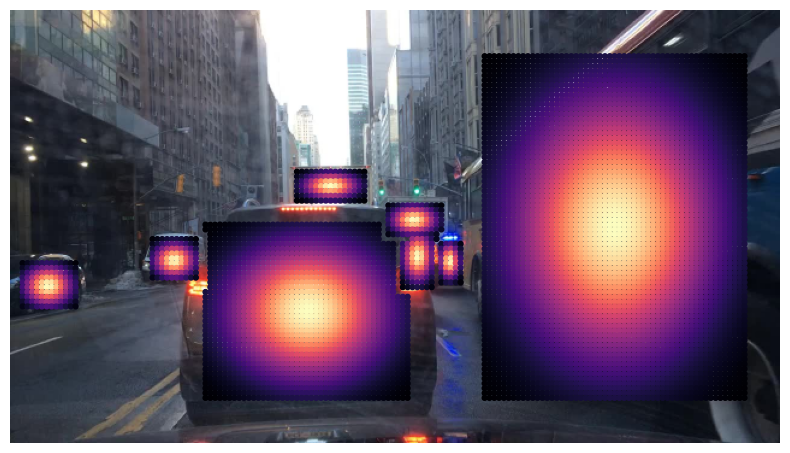

min centerness score:  0.019725975
max centerness score:  0.99975485


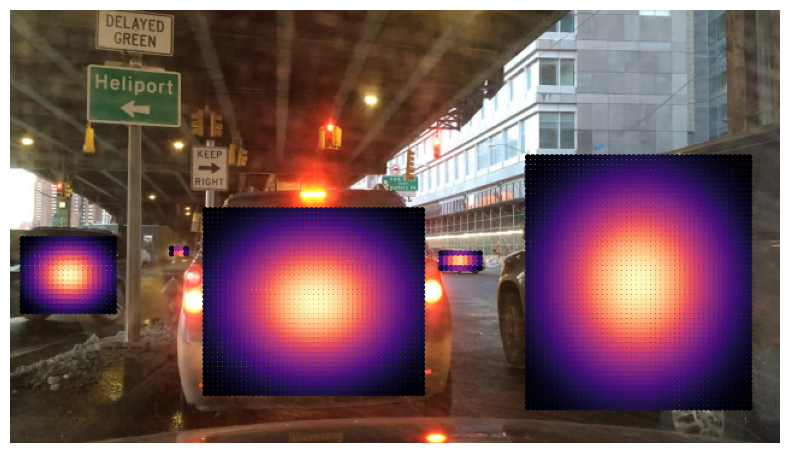

min centerness score:  0.020132722
max centerness score:  0.9998835


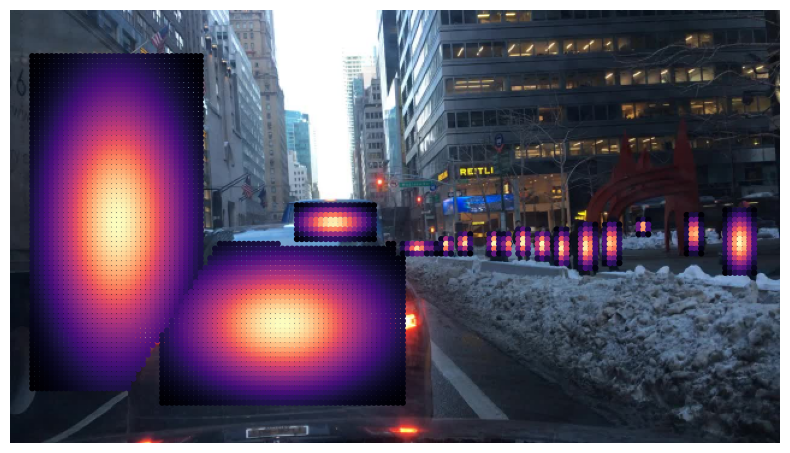

min centerness score:  0.019411644
max centerness score:  0.99932516


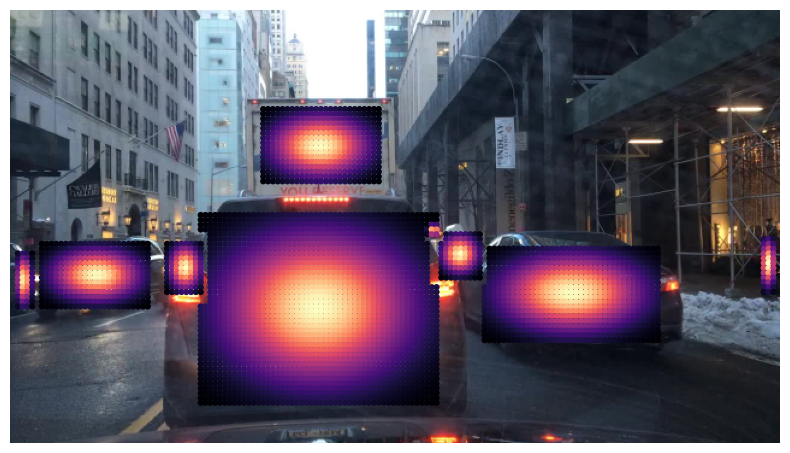

min centerness score:  0.020660771
max centerness score:  0.9993885


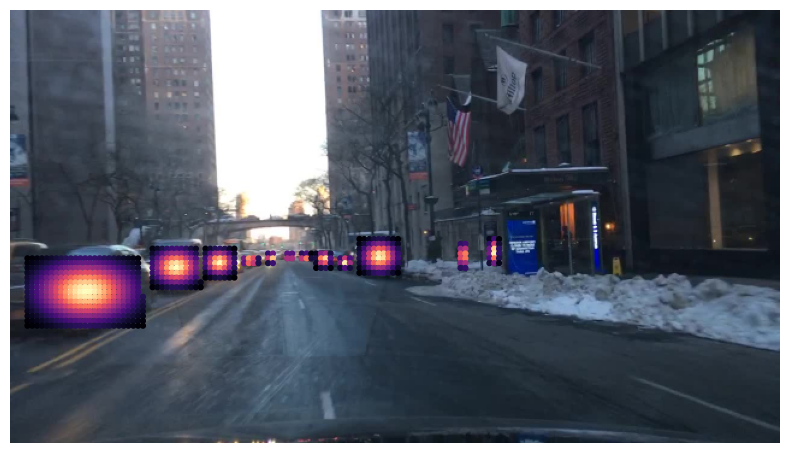

min centerness score:  0.022930473
max centerness score:  0.9983431


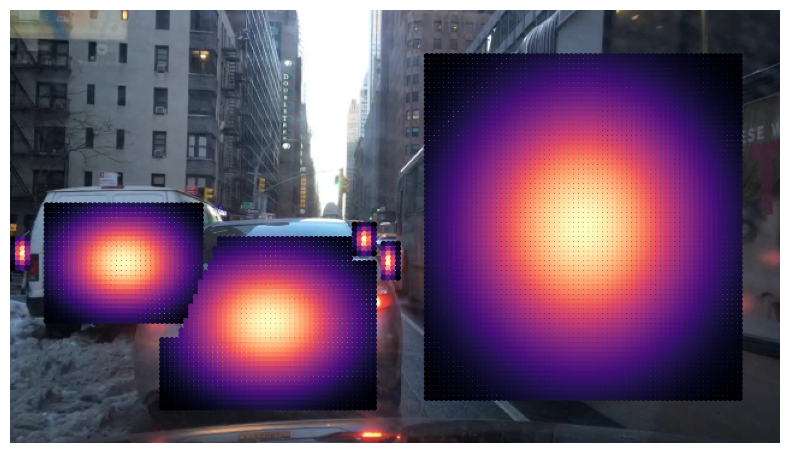

min centerness score:  0.019024855
max centerness score:  0.9997672


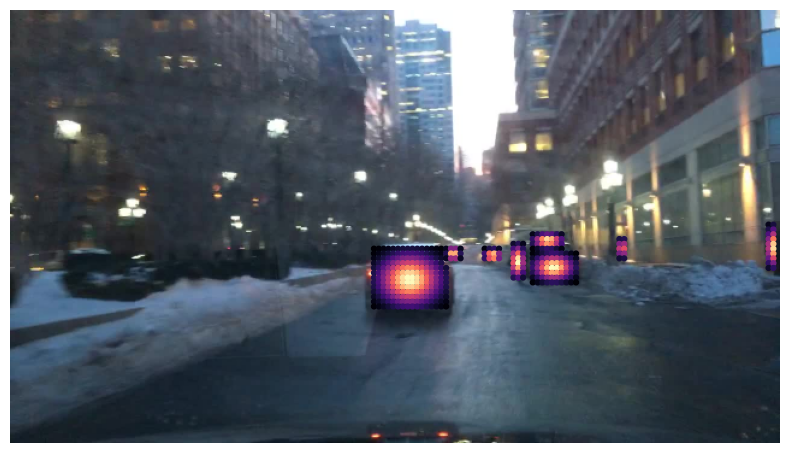

min centerness score:  0.022042742
max centerness score:  0.98658246


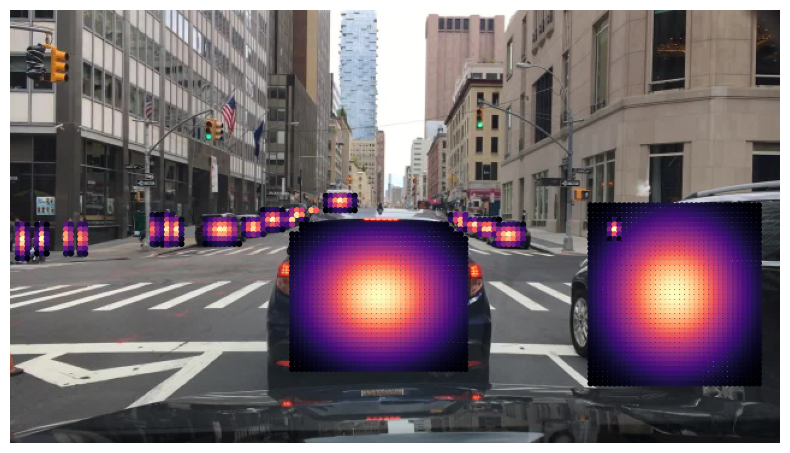

min centerness score:  0.018946934
max centerness score:  0.99966776


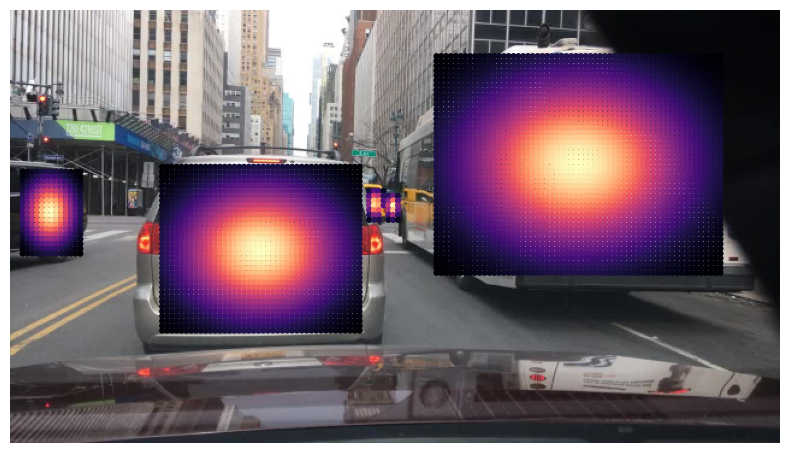

min centerness score:  0.020243665
max centerness score:  0.999477


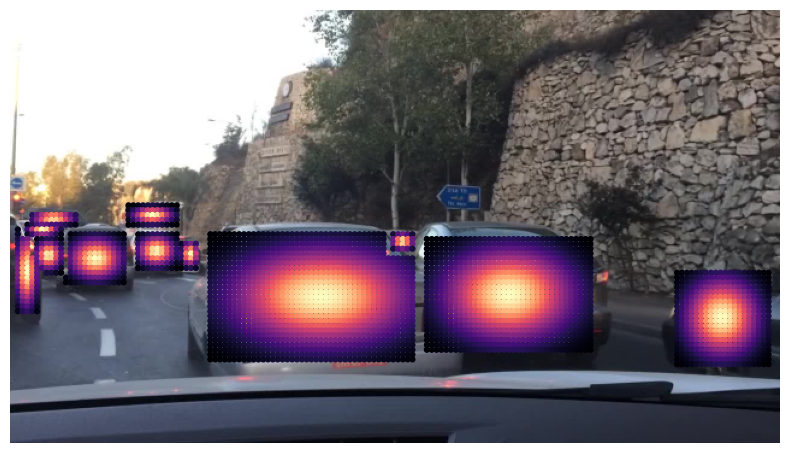

min centerness score:  0.020090813
max centerness score:  0.9999017


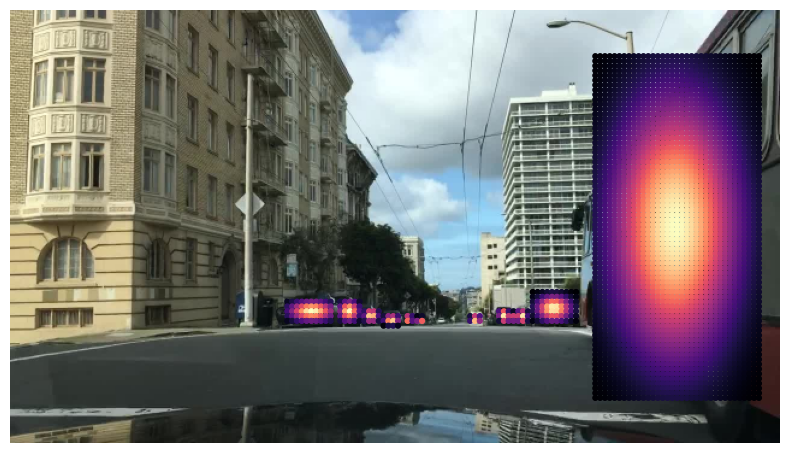

min centerness score:  0.019167908
max centerness score:  0.9987764


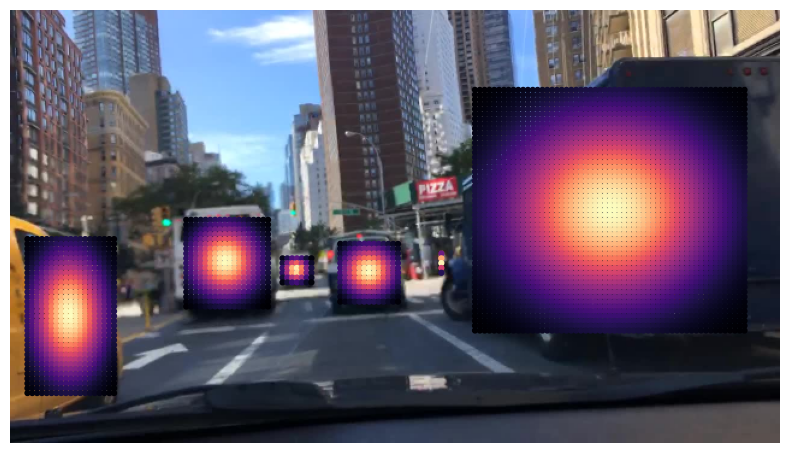

min centerness score:  0.01899198
max centerness score:  0.99992055


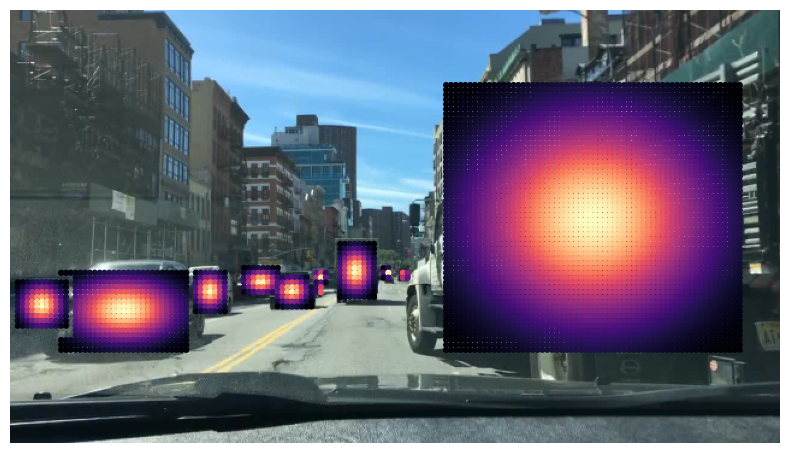

min centerness score:  0.019970985
max centerness score:  0.99955815


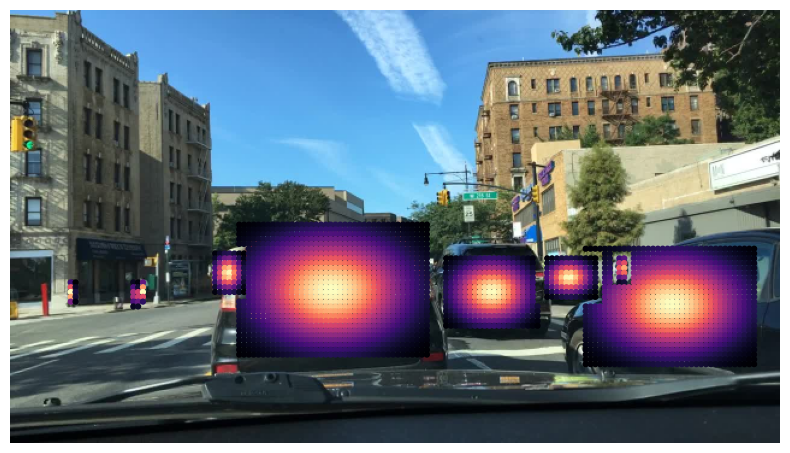

min centerness score:  0.020572884
max centerness score:  0.9985248


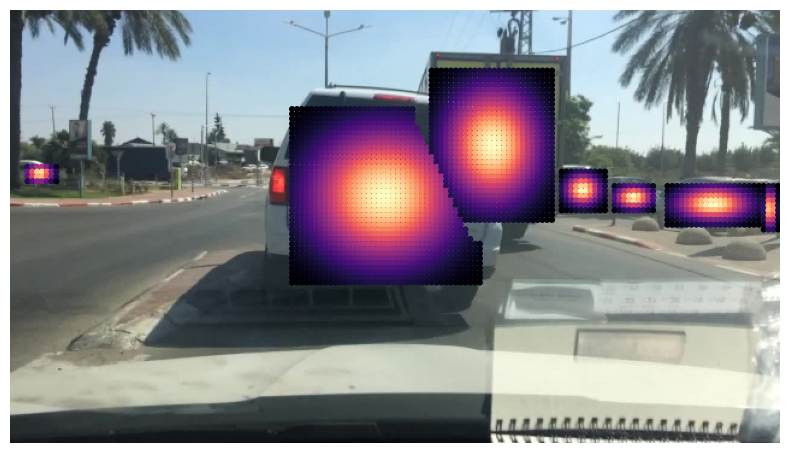

min centerness score:  0.020302722
max centerness score:  0.9997701


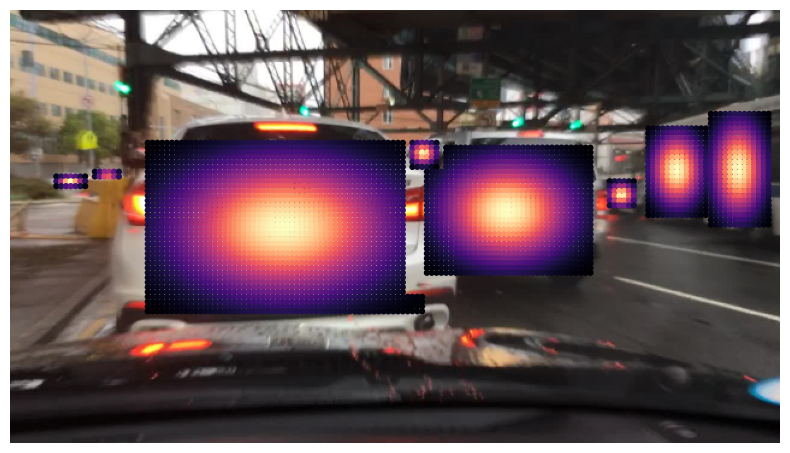

min centerness score:  0.019719345
max centerness score:  0.99956775


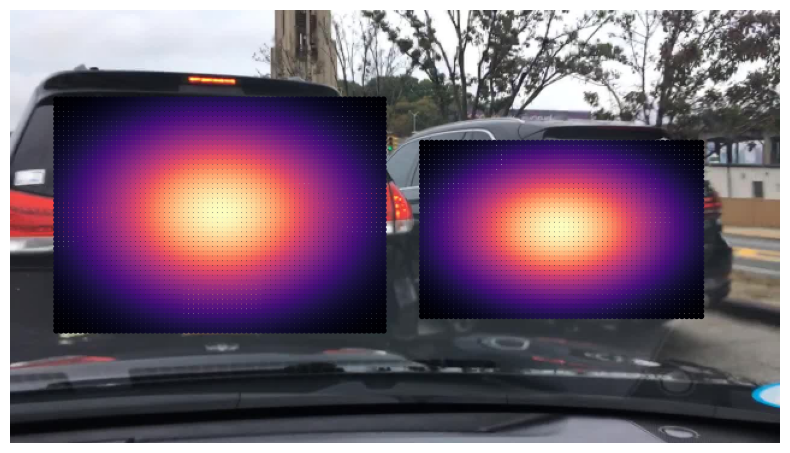

min centerness score:  0.01980253
max centerness score:  0.9994768


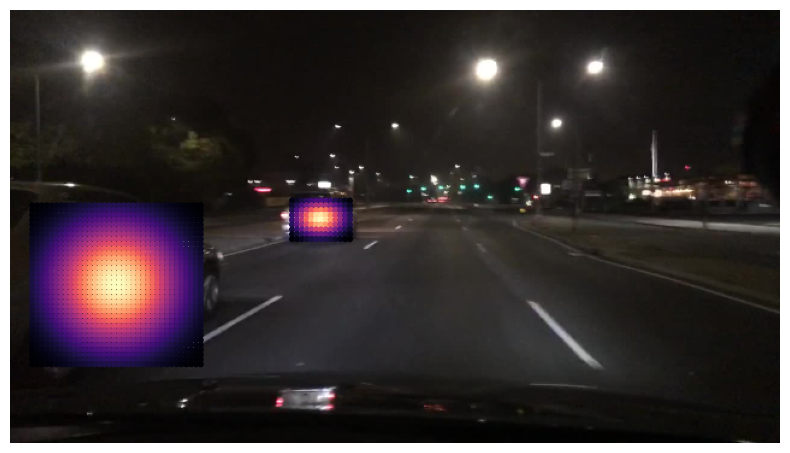

min centerness score:  0.021063557
max centerness score:  0.9971837


In [4]:
image_idx = [14, 15, 16, 17, 18, 19, 20, 27, 29, 37, 53, 61, 63, 64, 89, 92, 93, 99]

for i in range(len(image_idx)):
    image, labels = bdd_dataset.__getitem__(image_idx[i])
    img_path = labels['img_path']

    bbox, cls_label = extract_valid_bbox(labels['bbox'], labels['obj_class_label'])
    bbox = bbox.to(device)
    cls_label = cls_label.to(device)

    matched_gt_class, \
    matched_gt_boxes = fcos_match_locations_to_gt_main(
        grid_coord, bbox, cls_label, device, 
        _IGNORED_CLASS_DEFAULT_ID_, _SHRINK_FACTOR_, _MATCH_CRITERIA_)   # 'closest_box' or 'smallest_area'
    
    # deltas = fcos_get_deltas_from_locations(grid_coord, matched_gt_boxes, strides_w, strides_h)
    # centerness = compute_centerness(deltas)
    centerness = compute_centerness_gaussian(grid_coord, matched_gt_boxes, _SHRINK_FACTOR_CENTERNESS_)

    positive_mask = matched_gt_class >= 0
    valid_centerness = centerness[positive_mask].cpu().numpy()
    valid_grid_coord = grid_coord[positive_mask].cpu().numpy()
    colors = generate_color(valid_centerness)
    visualize_centerness(
        img_path, 
        constants._IMG_RESIZED_W_, 
        constants._IMG_RESIZED_H_,
        valid_grid_coord,
        colors, 
        size = 12.0,
        alpha = 1.0,
        figsize=(8,6))
    
    print('min centerness score: ', np.min(valid_centerness))
    print('max centerness score: ', np.max(valid_centerness))
    print('=' * 100)

In [5]:
np.min(valid_centerness)

0.021063557